In [1]:
import os
from collections import Counter
from pathlib import Path
import pandas as pd

In [2]:
raw_data_path = '../raw_data/'
raw_data_dir_names = ['ethan', 'sai']
raw_data_dirs = [raw_data_path+raw_data_dir_name for raw_data_dir_name in raw_data_dir_names]

In [3]:
counter = Counter()
paths = {}
for dir in raw_data_dirs:
    for file in Path(dir).rglob("*"):
        if file.is_file():
            doc_format = file.suffix.lower() if file.suffix else "no_extension"
            counter[doc_format]+=1
            list_of_paths = paths.get(doc_format,[])
            list_of_paths.append(str(file))
            paths[doc_format] = list_of_paths

In [4]:
documents_summary_df = pd.DataFrame(counter.items(), columns=["Document Format", "Document Count"])
documents_summary_df

,Document Format,Document Count
0,.ris,3
1,.html,43
2,.pdf,253
3,no_extension,2
4,.docx,1


In [5]:
valid_extensions = ['.html','.pdf','.docx']
metadata_extension = ['.ris']
total_documents = documents_summary_df[documents_summary_df["Document Format"].isin(valid_extensions)]["Document Count"].sum()

print(f"Total Document Count: {total_documents}")

Total Document Count: 297


## Extraction

In [26]:
import tqdm
import pdfplumber
from bs4 import BeautifulSoup
import docx

In [9]:
# pdf_paths = paths['.pdf']
# pdf_data = {
#     "text": [],
#     "num_tables":[],
#     "num_figures":[]
# }
# for pdf_path in tqdm.auto(pdf_paths):
#     with pdfplumber.open(pdf_path) as pdf:
#         pdf_len = len(pdf.pages)
#         text = ""
#         num_tables = 0
#         num_figures = 0
#         for page in pdf.pages:
#             text+=page.extract_text() or ""
#             num_tables+=len(page.find_tables())
#             num_figures+=len(page.images)
#         pdf_data["text"].append(text)
#         pdf_data["num_tables"].append(num_tables)
#         pdf_data["num_figures"].append(num_figures)

Cannot set gray stroke color because /'P11' is an invalid float value
Cannot set gray non-stroke color because /'P11' is an invalid float value
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Ca

In [16]:
from multiprocessing import Pool, cpu_count

def pdf_extract_data(pdf_path):
    try:
        with pdfplumber.open(pdf_path) as pdf:
            pdf_len = len(pdf.pages)
            text = ""
            num_tables = 0
            num_figures = 0
            for page in pdf.pages:
                text+=page.extract_text() or ""
                num_tables+=len(page.find_tables())
                num_figures+=len(page.images)
                return {
                    "text": text,
                    "num_tables": num_tables,
                    "num_figures": num_figures,
                    "error":0
                }
    except Exception as e:
        print(f"Error processing {pdf_path}: {e}")
        return {
            "text": "",
            "num_tables": 0,
            "num_figures": 0,
            "error": 1
        }

pdf_paths = paths['.pdf']
num_process = max(1, cpu_count()-1)

with Pool(processes=num_process) as pool:
    results = list(tqdm.tqdm(
                            pool.imap(pdf_extract_data, pdf_paths),
                            total=len(pdf_paths),
                            desc="Processing...")
                  )

pdf_data = {
    "text": [r["text"] for r in results],
    "num_tables": [r["num_tables"] for r in results],
    "num_figures": [r["num_figures"] for r in results],
    "errors":sum([r["error"] for r in results])
}


Processing...:   1%|          | 2/253 [00:03<06:15,  1.50s/it]Cannot set gray stroke color because /'P11' is an invalid float value
Cannot set gray non-stroke color because /'P11' is an invalid float value
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported

Processing...:   2%|▏         | 4/253 [00:04<03:08,  1.32it/s]Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported

Processing...:  48%|████▊     | 121/253 [00:15<00:13, 10.12it/s]

Error processing ../raw_data/sai/files/394/Mittal et al. - 2021 - Cancer Tissue Classification Using Supervised Mach.pdf: Unexpected EOF



Processing...:  66%|██████▌   | 167/253 [00:20<00:07, 11.83it/s]Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported

Processing...: 100%|██████████| 253/253 [00:26<00:00,  9.38it/s]


In [22]:
def html_extract_data(html_path):
    try:
        with open(html_path, 'r', encoding="utf-8") as html:
            soup = BeautifulSoup(html.read(), "html.parser")
    
            for element in soup.find_all(["script","style"]):
                element.decompose()
    
            text = soup.get_text()
            num_tables = len(soup.find_all("table"))
            num_figures = len(soup.find_all("figure")) + len(soup.find_all("img"))
    
            return {
                    "text": text,
                    "num_tables": num_tables,
                    "num_figures": num_figures,
                    "error":0
                    }
    except Exception as e:
        print(f"Error processing {html_path}: {e}")
        return {
            "text": "",
            "num_tables": 0,
            "num_figures": 0,
            "error": 1
        }
html_paths = paths['.html']
num_process = max(1, cpu_count()-1)
with Pool(processes=num_process) as pool:
    results = list(
                    tqdm.tqdm(
                        pool.imap(html_extract_data, html_paths),
                        total=len(html_paths),
                        desc="Processing...")
    )

html_data = {
    "text": [r["text"] for r in results],
    "num_tables": [r["num_tables"] for r in results],
    "num_figures": [r["num_figures"] for r in results],
    "errors":sum([r["error"] for r in results])
}


Processing...: 100%|██████████| 43/43 [00:03<00:00, 11.56it/s][A


In [27]:
def docx_extract_docx(docx_path):
    try:
        doc = docx.Document(docx_path)
        
        text = "\n".join([paragraph.text for paragraph in doc.paragraphs])
        return {
                "text": text,
                "num_tables": len(doc.tables),
                "num_figures": len([r for r in doc.part.rels.values() 
                      if "image" in r.target_ref]),
                "error":0
                }
    except Exception as e:
        print(f"Error processing {docx_path}: {e}")
        return {
            "text": "",
            "num_tables": 0,
            "num_figures": 0,
            "error": 1
        }
docx_paths = paths['.docx']
num_process = max(1, cpu_count()-1)
with Pool(processes=num_process) as pool:
    results = list(
                    tqdm.tqdm(
                        pool.imap(docx_extract_docx, docx_paths),
                        total=len(docx_paths),
                        desc="Processing...")
    )

docx_data = {
    "text": [r["text"] for r in results],
    "num_tables": [r["num_tables"] for r in results],
    "num_figures": [r["num_figures"] for r in results],
    "errors":sum([r["error"] for r in results])
}


Processing...: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


In [28]:
combined_data = {
    "text": [],
    "num_tables":[],
    "num_figures":[],
    "errors": 0
}
for data in [pdf_data, html_data, docx_data]:
    combined_data["text"].extend(data["text"])
    combined_data["num_tables"].extend(data["num_tables"])
    combined_data["num_figures"].extend(data["num_figures"])
    combined_data["errors"] = combined_data["errors"] + data["errors"]

## Exploration

### Text

In [87]:
import string
import re
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hakeem.at/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/hakeem.at/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/hakeem.at/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [70]:
def compute_text_stats(text):
    text_clean = re.sub(r'\s+', ' ', text).strip().lower()
    text_clean = text_clean.strip(string.punctuation)
    
    words = word_tokenize(text_clean)
    
    chars = [c for c in text if c.strip()]
    
    sentences = re.split(r'[.!?]+', text_clean)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    stats = {
        'total_chars': len(text),
        'total_chars_no_space': len(text.replace(' ', '')),
        'total_words': len(words),
        'total_sentences': len(sentences),
        'total_lines': text.count('\n'),
        
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'avg_sentence_length': np.mean([len(s.split()) for s in sentences]) if sentences else 0,
        
        'unique_words': len(set(words)),
        'vocabulary_richness': len(set(words)) / len(words) if words else 0,
        
        'word_freq_top10': Counter(words).most_common(10),
        'word_length_dist': Counter([len(w) for w in words]),
        
        'avg_chars_per_word': len(''.join(words)) / len(words) if words else 0,
    }
    
    return stats, words

list_of_text = combined_data["text"]
num_process = max(1, cpu_count()-1)
with Pool(processes=num_process) as pool:
    results = list(
                    tqdm.tqdm(
                        pool.imap(compute_text_stats, list_of_text),
                        total=len(list_of_text),
                        desc="Processing...")
    )

Processing...: 100%|██████████| 297/297 [00:01<00:00, 169.16it/s]


In [71]:
combined_stats = {
    'total_chars': [],
    'total_chars_no_space': [],
    'total_words': [],
    'total_sentences': [],
    'total_lines': [],
    'avg_word_length': [],
    'avg_sentence_length': [],
    'unique_words': [],
    'vocabulary_richness': [],
    'word_freq_top10': [],
    'word_length_dist': [],
    'avg_chars_per_word': [],
}

combined_words = []

for stats, words in results:
    combined_stats['total_chars'].append(stats['total_chars'])
    combined_stats['total_chars_no_space'].append(stats['total_chars_no_space'])
    combined_stats['total_words'].append(stats['total_words'])
    combined_stats['total_sentences'].append(stats['total_sentences'])
    combined_stats['total_lines'].append(stats['total_lines'])
    combined_stats['avg_word_length'].append(stats['avg_word_length'])
    combined_stats['avg_sentence_length'].append(stats['avg_sentence_length'])
    combined_stats['unique_words'].append(stats['unique_words'])
    combined_stats['vocabulary_richness'].append(stats['vocabulary_richness'])
    combined_stats['word_freq_top10'].append(stats['word_freq_top10'])
    combined_stats['word_length_dist'].append(stats['word_length_dist'])
    combined_stats['avg_chars_per_word'].append(stats['avg_chars_per_word'])
    
    combined_words.extend(words)

In [72]:
average_chars_per_doc = np.mean(combined_stats['total_chars_no_space'])
average_words_per_doc = np.mean(combined_stats['total_words'])
average_sentences_per_doc = np.mean(combined_stats['total_sentences'])
total_vocabulary_size = len(set(combined_words))
most_freq_word10 = Counter(combined_words).most_common(10)
stop_words = set(stopwords.words('english'))
cleaned_combined_words = [word for word in tqdm.tqdm(combined_words) 
                          if word not in stop_words and word.isalpha()]
cleaned_most_freq_word10 = Counter(cleaned_combined_words).most_common(10)

100%|██████████| 529236/529236 [00:00<00:00, 2998304.40it/s]


In [73]:
summary_stats = pd.DataFrame({
    'Metric': [
        'Documents Processed',
        'Average Characters per Document',
        'Average Words per Document',
        'Average Sentences per Document',
        'Total Unique Vocabulary',
        'Total Words (with stopwords)',
        'Total Words (without stopwords)',
        'Stopwords Removed',
        'Stopword Percentage'
    ],
    'Value': [
        f"{len(combined_stats['total_words']):,}",
        f"{average_chars_per_doc:,.0f}",
        f"{average_words_per_doc:,.0f}",
        f"{average_sentences_per_doc:,.1f}",
        f"{total_vocabulary_size:,}",
        f"{len(combined_words):,}",
        f"{len(cleaned_combined_words):,}",
        f"{len(combined_words) - len(cleaned_combined_words):,}",
        f"{(1 - len(cleaned_combined_words)/len(combined_words))*100:.1f}%"
    ]
})

summary_stats

,Metric,Value
0,Documents Processed,297
1,Average Characters per Document,"9,543"
2,Average Words per Document,"1,782"
3,Average Sentences per Document,129.5
4,Total Unique Vocabulary,"39,144"
5,Total Words (with stopwords),"529,236"
6,Total Words (without stopwords),"253,005"
7,Stopwords Removed,"276,231"
8,Stopword Percentage,52.2%


In [74]:
cleaned_most_freq_word10

[('data', 3044),
 ('mass', 2511),
 ('et', 1911),
 ('imaging', 1818),
 ('analysis', 1581),
 ('msi', 1464),
 ('tissue', 1457),
 ('spectrometry', 1336),
 ('spatial', 1324),
 ('image', 1165)]

(array([204.,  52.,   5.,   2.,   0.,   3.,   6.,   0.,   1.,   0.,   2.,
          0.,   4.,   3.,   1.,   3.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([    0.  ,   685.78,  1371.56,  2057.34,  2743.12,  3428.9 ,
         4114.68,  4800.46,  5486.24,  6172.02,  6857.8 ,  7543.58,
         8229.36,  8915.14,  9600.92, 10286.7 , 10972.48, 11658.26,
        12344.04, 13029.82, 13715.6 , 14401.38, 15087.16, 15772.94,
        16458.72, 17144.5 , 17830.28, 18516.06, 19201.84, 19887.62,
        20573.4 , 21259.18, 21944.96, 22630.74, 23316.52, 24002.3 ,
        24688.08, 25373.86, 26059.64, 26745.42, 27431.2 , 28116.98,
        28802.76, 29488.54, 30174.32, 30860.1 , 31545.88, 32231.66,
        32917.44, 33603.22, 34289.  ]),
 <BarContainer object of 50 artists>)

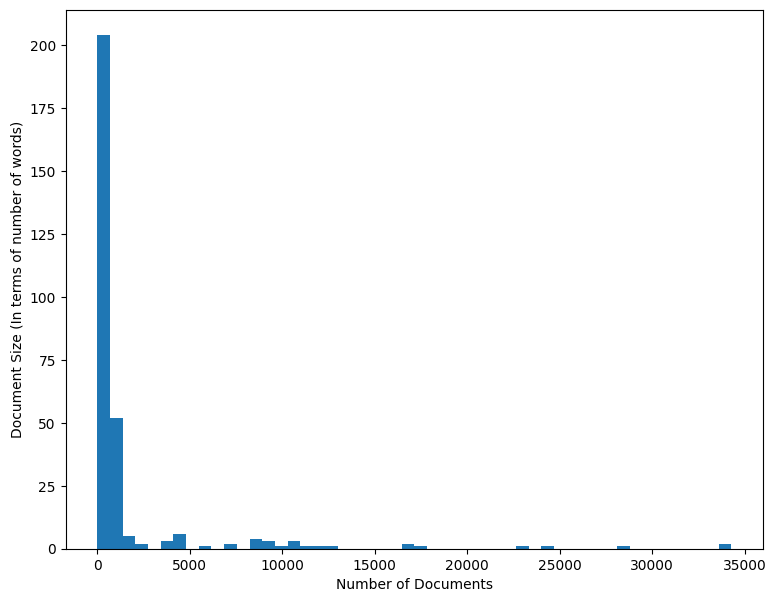

In [94]:
plt.figure(figsize=(9, 7))
# plt.title("Document Size Distribution")
plt.xlabel("Number of Documents")
plt.ylabel("Document Size (In terms of number of words)")
plt.hist(combined_stats["total_words"], bins=50)

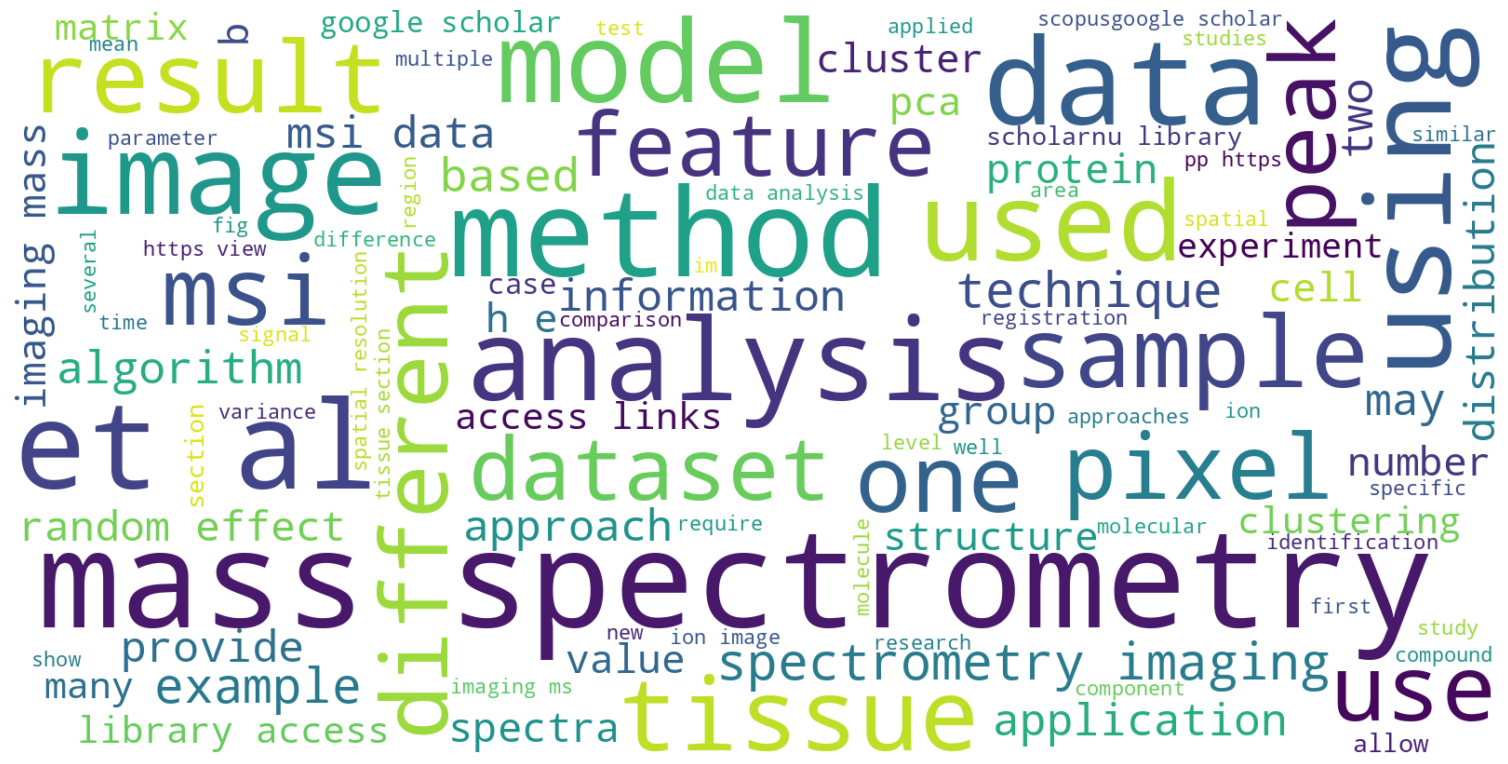

In [95]:
wordcloud = WordCloud(width=1600, height=800, 
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(' '.join(cleaned_combined_words))

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title("Word Cloud", fontsize=40, pad=20)
plt.tight_layout(pad=2)
plt.show()

In [104]:
from transformers import AutoTokenizer

In [ ]:
tokenizers_config = [
    ("stanford-crfm/BioMedLM", "BioMedLM-2.7B"),
    ("meta-llama/Meta-Llama-3.1-8B-Instruct", "Llama-3.1-8B"),
    ("mistralai/Mistral-7B-Instruct-v0.3", "Mistral-7B-v0.3"),
    ("Qwen/Qwen2.5-7B-Instruct", "Qwen2.5-7B"),
    ("google/gemma-2-9b-it", "Gemma-2-9B")
]

model_token_counter = {}
full_text = ""
for text in combined_data["text"]:
    full_text+=text
for model_id, name in tokenizers_config:
    print(f"\n📊 {name}")
    tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
    
    tokens = tokenizer.tokenize(full_text)
    counts = Counter(tokens)
    model_token_counter[name] = counts
    print(f"\nMost Common Tokens (Top 10)")
    print(counts.most_common(50))
    print("="*100)



📊 BioMedLM-2.7B


Token indices sequence length is longer than the specified maximum sequence length for this model (856773 > 1024). Running this sequence through the model will result in indexing errors



Most Common Tokens (Top 10)
[('Ċ', 40049), ('.', 33005), (',', 30732), ('Ġthe', 19041), ('Ġof', 15036), ('-', 13340), ('Ġand', 10877), ('Ġin', 7877), ('Ġto', 7730), ('Ġ(', 7724), ('Ġa', 6511), (')', 5198), ('Ġfor', 4899), ('Ġis', 4523), ('ł', 4317), ('Â', 4300), ('/', 4152), ('âĢ', 3556), ('Ġ', 3542), (':', 3431), ('s', 3087), ('Ġdata', 3004), ('Ġwith', 2967), ('MS', 2653), ('Ġthat', 2605), ('1', 2568), ('i', 2523), ('Ġas', 2490), ('Ġare', 2394), ('2', 2310), ('Ġby', 2294), ('o', 2226), ('Ġ[', 2155), ('10', 2083), ('Ġbe', 2031), ('Ġmass', 2031), ('Ġon', 1974), ('ĠThe', 1971), (').', 1949), ('Ġal', 1927), ('M', 1852), ('S', 1826), (';', 1821), ('),', 1810), ('I', 1807), ('D', 1806), ('(', 1768), ('and', 1761), ('ĠS', 1742), ('G', 1714)]

📊 Llama-3.1-8B


Token indices sequence length is longer than the specified maximum sequence length for this model (759953 > 131072). Running this sequence through the model will result in indexing errors



Most Common Tokens (Top 10)
[(',', 28223), ('.', 23660), ('Ġthe', 19036), ('Ġof', 15034), ('Ċ', 12523), ('Ġand', 10878), ('Ġ', 10658), ('Ġin', 7922), ('Ġto', 7724), ('Ġ(', 7701), ('Ġa', 6502), ('Ġfor', 4894), (')', 4815), ('Ġis', 4650), ('1', 4162), ('-', 3509), ('2', 3327), ('Âł', 3230), (':', 3068), ('Ġdata', 3009), ('Ġwith', 2966), ('Ġthat', 2605), ('Ġas', 2489), ('201', 2423), ('Ġare', 2394), ('3', 2339), ('Ġby', 2296), ('Ġ[', 2148), ('0', 2081), ('Ġmass', 2031), ('Ġbe', 2028), ('Ġon', 1975), ('ĠThe', 1954), ('Ġal', 1905), ('rom', 1853), ('4', 1843), ('),', 1783), ('10', 1767), (';', 1727), ('Ġfrom', 1706), (').', 1686), ('/', 1639), ('5', 1633), ('etry', 1631), ('Ġet', 1576), ('.,', 1571), ('Ġimaging', 1524), ('Ġanalysis', 1518), ('of', 1516), ('Ġtissue', 1465)]

📊 Mistral-7B-v0.3


tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

### Figures

In [100]:
total_tables = sum(combined_data['num_tables'])
total_figures = sum(combined_data['num_figures'])
avg_tables_per_doc = np.mean(combined_data['num_tables'])
avg_figures_per_doc = np.mean(combined_data['num_figures'])
median_tables_per_doc = np.median(combined_data['num_tables'])
median_figures_per_doc = np.median(combined_data['num_figures'])

tables_figures_stats = pd.DataFrame({
    'Metric': [
        'Total Tables',
        'Total Figures',
        'Average Tables per Document',
        'Average Figures per Document',
        'Median Tables per Document',
        'Median Figures per Document',
        'Documents with Tables',
        'Documents with Figures'    ],
    'Value': [
        f"{total_tables:,}",
        f"{total_figures:,}",
        f"{avg_tables_per_doc:.2f}",
        f"{avg_figures_per_doc:.2f}",
        f"{median_tables_per_doc:.1f}",
        f"{median_figures_per_doc:.1f}",
        f"{sum(1 for t in combined_data['num_tables'] if t > 0):,}",
        f"{sum(1 for f in combined_data['num_figures'] if f > 0):,}",
    ]
})
tables_figures_stats

,Metric,Value
0,Total Tables,155
1,Total Figures,"2,148"
2,Average Tables per Document,0.52
3,Average Figures per Document,7.23
4,Median Tables per Document,0.0
5,Median Figures per Document,1.0
6,Documents with Tables,91
7,Documents with Figures,201


(array([206.,  46.,   0.,  33.,   0.,   7.,   4.,   0.,   0.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

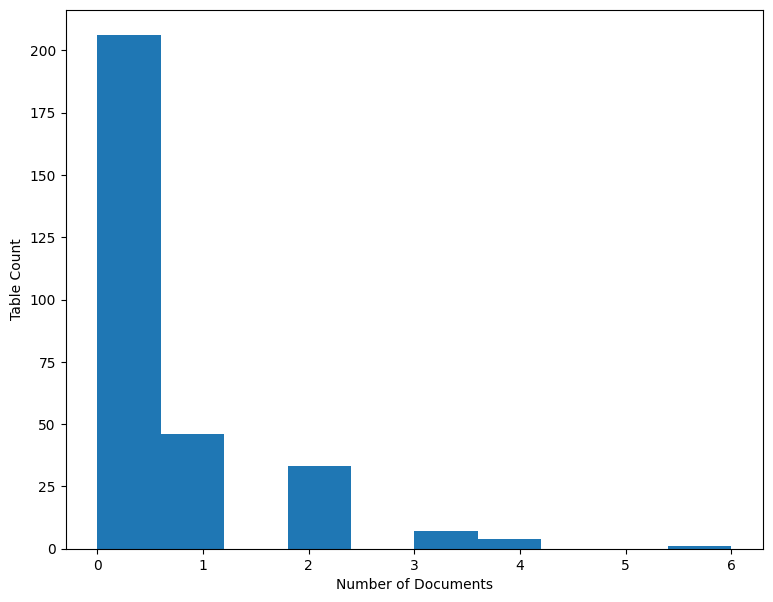

In [101]:
plt.figure(figsize=(9, 7))
# plt.title("Document Size Distribution")
plt.xlabel("Number of Documents")
plt.ylabel("Table Count")
plt.hist(combined_data["num_tables"], bins=10)

(array([286.,   7.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([  0. ,  34.8,  69.6, 104.4, 139.2, 174. , 208.8, 243.6, 278.4,
        313.2, 348. ]),
 <BarContainer object of 10 artists>)

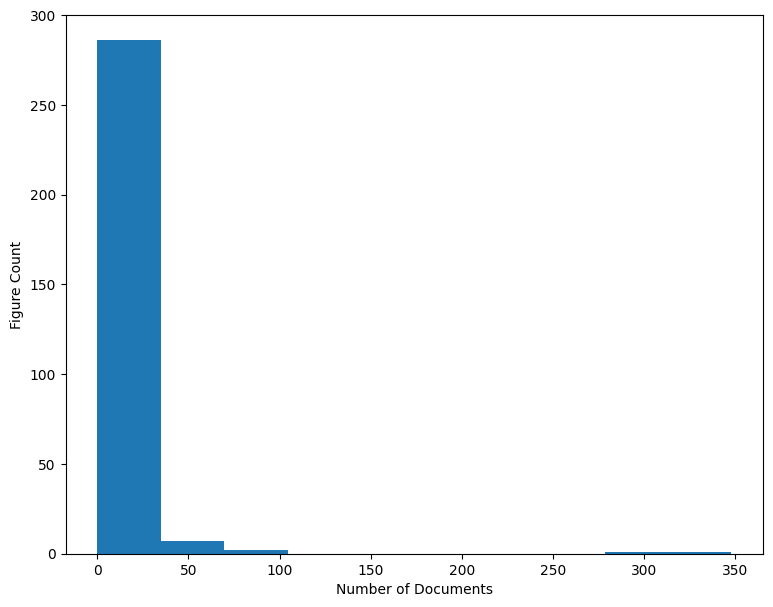

In [102]:
plt.figure(figsize=(9, 7))
# plt.title("Document Size Distribution")
plt.xlabel("Number of Documents")
plt.ylabel("Figure Count")
plt.hist(combined_data["num_figures"], bins=10)